# Accessibility of London foodbanks

## 1. Get foodbanks --> see other notebook

1. Independent foodbanks: Data from list published in the [Guardian](https://www.theguardian.com/society/2017/may/29/report-reveals-scale-of-food-bank-use-in-the-uk-ifan). 
2. Trussell Trust foodbanks listed on their [website](https://www.trusselltrust.org/get-help/find-a-foodbank/)

## 2.  Get isochrones

Get isochrones using [openrouteservice](https://openrouteservice.org/). The free version has a limit of 500 isochrones per day, so had to split the pulling of data into chunks and run over two days. 

In [1]:
import configparser
import os
import sys
import time

import openrouteservice
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

#set config file
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

In [2]:
# Get API key
config = configparser.ConfigParser()
config.read(config_file)
apikey = config["openroutingservice"]["key"]
client = openrouteservice.Client(key=apikey)

In [165]:
#load foodbanks
gdf = gpd.GeoDataFrame.from_file("foodbanks-london-final.geojson")

# coordinates of all foodbanks
coords = list(zip(gdf['lon'].astype(float), gdf['lat'].astype(float)))

len(coords)

226

In [179]:
# put it all  in a loop
iso = []

#for coord in coords[0:10]:
for coord in coords:
    location = [coord]
    #print(location)
    response = openrouteservice.isochrones.isochrones(client, location, profile='foot-walking',
                                                      range_type='time', range=[600], location_type="start", 
                                                      smoothing=0,attributes=["area"], validate=True)
    
    data = {"center": [], "time": [], "geometry": [] }
    for isochrone in response['features']:
        data["center"].append(isochrone["properties"]["center"])
        data["time"].append(isochrone["properties"]["value"])
        data["geometry"].append(Polygon([list(coord) for coord in isochrone['geometry']['coordinates'][0]]))
    
    df_single = pd.DataFrame.from_dict(data)
    iso.append(df_single)
    time.sleep(3)
    
iso = pd.concat(iso, axis=0, ignore_index=True)

#convert isochrones to geo dataframe
iso = gpd.GeoDataFrame(iso, crs="EPSG:4326", geometry="geometry").sort_values("time", ascending=False)

In [181]:
# save output as geojson
iso["center_lat"] = iso["center"].str[1]
iso["center_lon"] = iso["center"].str[0]
iso = iso.drop(columns="center")
iso.to_file("isochrones-walking-10min.geojson", driver='GeoJSON')
#iso.to_file("isochrones-walking-20min.geojson", driver='GeoJSON')
#iso.to_file("isochrones-walking-30min.geojson", driver='GeoJSON')

### Prepare for mapping

In [6]:
# load individual files
iso_10 =  gpd.GeoDataFrame.from_file("isochrones-walking-10min.geojson")
iso_30 = gpd.GeoDataFrame.from_file("isochrones-walking-30min.geojson")
iso_20 = gpd.GeoDataFrame.from_file("isochrones-walking-20min.geojson")

#combine into single dataframe
iso = pd.concat([iso_10, iso_20, iso_30])

In [7]:
## join polygons where they overlap
times = []
geometry = []

for seconds in iso["time"].astype(int).unique():
    times.append(seconds)
    union = iso[iso["time"]==seconds]["geometry"].unary_union
    geometry.append(union)

iso_combined = pd.DataFrame()

iso_combined["time"] = times
iso_combined["geometry"] = geometry 
iso_combined = gpd.GeoDataFrame(iso_combined, crs="EPSG:4326", geometry="geometry").sort_values("time", ascending=False)

C:\Users\lisa.hornung\anaconda3\envs\py3_maps\lib\site-packages\pandas\core\dtypes\cast.py:1785: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [8]:
iso_combined

,time,geometry
3,1800,"MULTIPOLYGON (((-0.59646 51.30582, -0.60205 51..."
2,1200,"MULTIPOLYGON (((-0.29835 51.35988, -0.30125 51..."
1,600,"MULTIPOLYGON (((-0.30874 51.36756, -0.30849 51..."
0,300,"MULTIPOLYGON (((-0.30917 51.36307, -0.31334 51..."


## 3. Map

Useful article on how to clip polygons in [geopandas](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/vector-data-processing/clip-vector-data-in-python-geopandas-shapely/)

In [5]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt

In [51]:
from matplotlib import font_manager
#set fonts
label_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Muli-Regular.ttf')
footer_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Muli-Regular.ttf')
title_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\OpenSans-SemiBold.ttf')

In [79]:
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [9]:
# load London borough and create background shape
la = gpd.GeoDataFrame.from_file("London_Borough_Excluding_MHW.geojson")
london_shape = gpd.GeoDataFrame({'name': ['london'], 'geometry': la.to_crs(4326).unary_union}, crs="EPSG:4326")

#clip isochrones to London shape
iso_combined_clipped = gpd.clip(iso_combined, london_shape)

,name,geometry
0,london,"POLYGON ((-0.16222 51.32449, -0.16291 51.32502..."


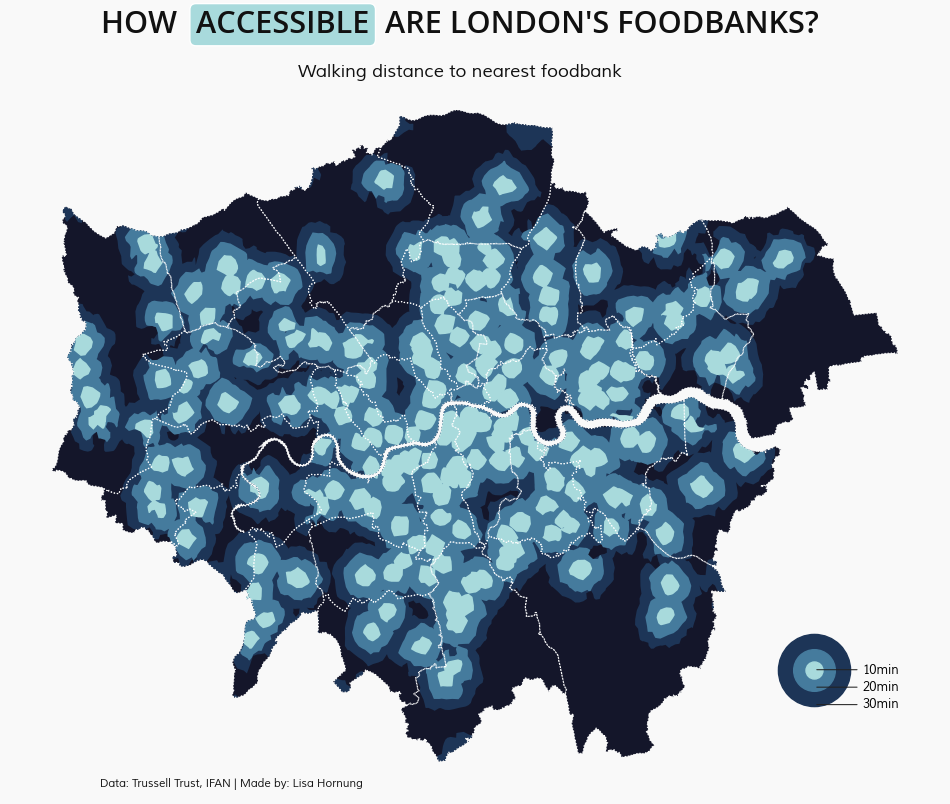

In [78]:
cols = {"bg": "#f9f9f9", "text": "#111111", "london": "#14162A",
        "10min": "#A8DADC", "20min":"#457B9D", "30min": "#1D3557"}
cols_red = ["#fff7ec", "#fdc38d","#fc8d59", "#e7533a", "#bf100a" ,"#7f0000" ]
cols_viridis = ["#fde725", "#95d840","#3cbb75", "#1f968b", "#2d708e" ,"#404788" , "#440d54"]
iso_plot = iso_combined_clipped

#Setup figure
fig,ax = plt.subplots(figsize=(12, 12))
fig.set_facecolor(cols["bg"])

#===========
#London shape and isochrones
london_shape.plot(ax=ax, color=cols["london"])
iso_plot[iso_plot["time"]==1800].plot(ax=ax, color=cols["30min"], alpha=1, zorder=2)
iso_plot[iso_plot["time"]==1200].plot(ax=ax, color=cols["20min"], alpha=1, zorder=2)
iso_plot[iso_plot["time"]==600].plot(ax=ax, color=cols["10min"], alpha=1, zorder=2)
la.to_crs(4326).boundary.plot(ax=ax, color="white", alpha=1, zorder=3, linewidth=0.85, linestyle="dotted")
ax.axis("off")

#===========
# legend
ax1 = fig.add_axes([0.72,0.25,0.15,0.1], anchor='NE', zorder=2)
for i,color in enumerate([cols["30min"], cols["20min"], cols["10min"]]):
    ax1.scatter(0.5,0.5, s=[2700,900,150][i], color=color, alpha=1)
kw = dict(arrowstyle="-", color="#222222", linewidth=0.75)
ax1.annotate("10min", xy=(0.50, 0.50), xycoords='data', xytext=(35,0), textcoords='offset points', fontproperties=label_font,
             annotation_clip=False, ha='left', va='center', fontsize=9, arrowprops=dict(**kw, clip_on=False))
ax1.annotate("20min", xy=(0.50, 0.492), xycoords='data', xytext=(35,0), textcoords='offset points', fontproperties=label_font,
             annotation_clip=False, ha='left', va='center', fontsize=9, arrowprops=dict(**kw, clip_on=False))
ax1.annotate("30min", xy=(0.50, 0.484), xycoords='data', xytext=(35,0), textcoords='offset points', fontproperties=label_font,
             annotation_clip=False, ha='left', va='center', fontsize=9,arrowprops=dict(**kw, clip_on=False))
#ax1.text(0.485, 0.53,"Walking distance", fontsize=9, ha="left")
ax1.axis("off")

#===========
#title and footer
plt.figtext(0.5,0.85, "How                          are London's foodbanks?".upper(), 
            va='top', ha="center", fontsize=22, color=cols["text"], fontproperties=title_font)
plt.figtext(0.28,0.85, "accessible".upper(), va='top', ha="left", fontsize=22, color=cols["text"],
            bbox=dict(facecolor=cols["10min"], edgecolor='white', boxstyle='round', pad=0.2, alpha=1),
           fontproperties=title_font)
plt.figtext(0.5,0.805, "Walking distance to nearest foodbank", va='top', ha="center", fontsize=13, 
            color=cols["text"], fontproperties=label_font)
plt.figtext(0.2,0.21, "Data: Trussell Trust, IFAN | Made by: Lisa Hornung", va='top', ha="left", 
            fontsize=8, color=cols["text"], fontproperties=label_font)

#===========
#save
plt.savefig("london-foodbanks-accessibility.png", bbox_inches='tight',  transparent=False, pad_inches=0.2)

plt.show()

# Other

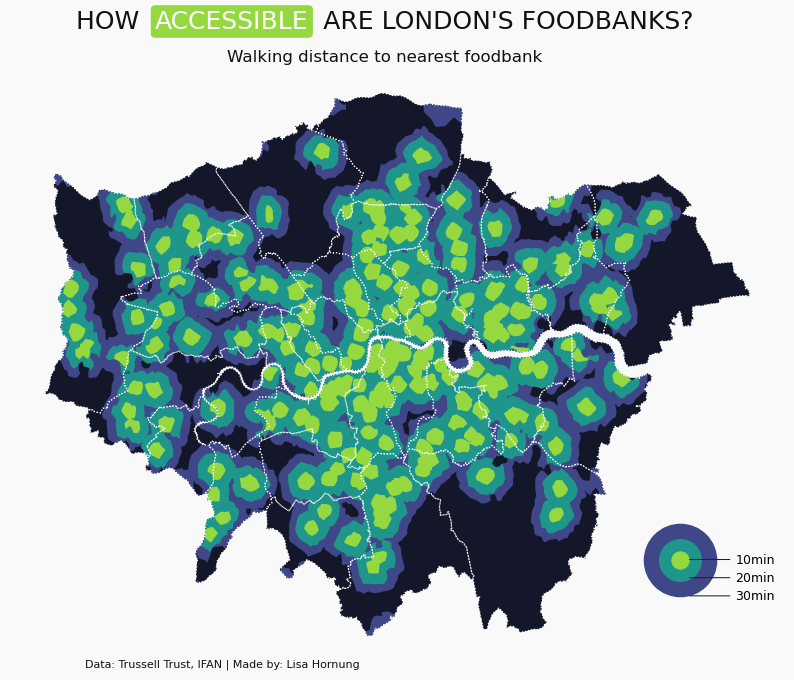

In [36]:
cols = {"bg": "#f9f9f9", "text": "#111111", "london": "#14162A", "10min": "#95d840", "20min":"#1f968b", 
        "30min": "#404788"}
cols_red = ["#fff7ec", "#fdc38d","#fc8d59", "#e7533a", "#bf100a" ,"#7f0000" ]
cols_viridis = ["#fde725", "#95d840","#3cbb75", "#1f968b", "#2d708e" ,"#404788" , "#440d54"]
iso_plot = iso_combined_clipped

#Setup figure
fig,ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor(cols["bg"])

#===========
#London shape and isochrones
london_shape.plot(ax=ax, color=cols["london"])
iso_plot[iso_plot["time"]==1800].plot(ax=ax, color=cols["30min"], alpha=1, zorder=2)
iso_plot[iso_plot["time"]==1200].plot(ax=ax, color=cols["20min"], alpha=1, zorder=2)
iso_plot[iso_plot["time"]==600].plot(ax=ax, color=cols["10min"], alpha=1, zorder=2)
la.to_crs(4326).boundary.plot(ax=ax, color="white", alpha=1, zorder=3, linewidth=0.85, linestyle="dotted")
ax.axis("off")

#===========
# legend
ax1 = fig.add_axes([0.72,0.25,0.15,0.1], anchor='NE', zorder=2)
for i,color in enumerate(["#404788","#1f968b","#95d840"]):
    ax1.scatter(0.5,0.5, s=[2700,900,150][i], color=color, alpha=1)
kw = dict(arrowstyle="-", color="#222222", linewidth=0.75)
ax1.annotate("10min", xy=(0.5025, 0.50), xycoords='data', xytext=(35,0), textcoords='offset points', 
             annotation_clip=False, ha='left', va='center', fontsize=9, arrowprops=dict(**kw, clip_on=False))
ax1.annotate("20min", xy=(0.5025, 0.49), xycoords='data', xytext=(35,0), textcoords='offset points', 
             annotation_clip=False, ha='left', va='center', fontsize=9, arrowprops=dict(**kw, clip_on=False))
ax1.annotate("30min", xy=(0.5025, 0.48), xycoords='data', xytext=(35,0), textcoords='offset points', 
             annotation_clip=False, ha='left', va='center', fontsize=9,arrowprops=dict(**kw, clip_on=False))
#ax1.text(0.485, 0.53,"Walking distance", fontsize=9, ha="left")
ax1.axis("off")

#===========
#title and footer
plt.figtext(0.5,0.85, "How                       are London's foodbanks?".upper(), 
            va='top', ha="center", fontsize=18, color=cols["text"])
plt.figtext(0.27,0.85, "accessible".upper(), va='top', ha="left", fontsize=18, color="white",
            bbox=dict(facecolor=cols["10min"], edgecolor='white', boxstyle='round', pad=0.2, alpha=1))
plt.figtext(0.5,0.81, "Walking distance to nearest foodbank", va='top', ha="center", fontsize=12, color=cols["text"])
plt.figtext(0.2,0.2, "Data: Trussell Trust, IFAN | Made by: Lisa Hornung", va='top', ha="left", 
            fontsize=8, color=cols["text"])

#===========
#save


plt.show()

## London LSOAs

In [26]:
# get regions and lsoa
regions = pd.read_csv("Local_Authority_District_to_Region_(April_2021)_Lookup_in_England.csv")
lsoa = pd.read_csv("OA21_LSOA21_MSOA21_LAD22_EW_LU.csv")

#filter for London
regions = regions[regions["RGN21NM"]=="London"]
london_lsoa = pd.merge(lsoa, regions, left_on="lad22cd", right_on="LAD21CD", how="inner")

C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_2396\2058746312.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  lsoa_lookup = pd.read_csv("OA21_LSOA21_MSOA21_LAD22_EW_LU.csv")


In [42]:
### London LSOA shapefile
london = gpd.GeoDataFrame.from_file("LSOA_(Dec_2021)_Boundaries_Full_Clipped_EW_(BFC).shp")
london = london[london["LSOA21CD"].isin(london_lsoa["lsoa21cd"].unique())]

In [43]:
london

,OBJECTID,LSOA21CD,LSOA21NM,GlobalID,Shape__Are,Shape__Len,geometry
0,1,E01000001,City of London 001A,92527a6c-53df-4e35-b1f3-5c2d7d656d70,1.298653e+05,2635.767993,"POLYGON ((532151.537 181867.433, 532152.500 18..."
1,2,E01000002,City of London 001B,44c8af04-33f1-4750-96d9-160188d60c32,2.284198e+05,2707.816821,"POLYGON ((532634.497 181926.016, 532632.048 18..."
2,3,E01000003,City of London 001C,c41a09e9-7e85-48c3-b7cb-b1b5cdf77579,5.905420e+04,1224.573160,"POLYGON ((532153.703 182165.155, 532158.250 18..."
3,4,E01000005,City of London 001E,b379f8ac-8a7d-4327-ac2b-93a8981454f5,1.895777e+05,2275.805344,"POLYGON ((533619.062 181402.364, 533639.868 18..."
4,5,E01000006,Barking and Dagenham 016A,2c7c35e9-2a95-48d7-b30c-cc01f36094d5,1.465370e+05,1966.092607,"POLYGON ((545126.852 184310.838, 545145.213 18..."
...,...,...,...,...,...,...,...
33711,33712,E01035718,Westminster 019G,9538ba5f-679a-4654-8263-5d504bfd8546,2.671900e+06,10740.132994,"POLYGON ((528044.949 180617.984, 528046.344 18..."
33712,33713,E01035719,Westminster 021F,83cbd77a-6a49-4ffe-aa13-683f1428dac1,9.294961e+04,2013.141792,"POLYGON ((530267.000 178811.300, 530265.750 17..."
33713,33714,E01035720,Westminster 021G,ad242c27-b5d0-494b-af4b-0eeb1e9cb6a0,1.061637e+05,2229.186337,"POLYGON ((529856.151 178761.747, 529856.859 17..."
33714,33715,E01035721,Westminster 023H,db86fa3a-db44-430e-82e0-e1e8ce83a68a,2.168432e+05,2738.810595,"POLYGON ((528641.815 178630.886, 528635.688 17..."


<AxesSubplot: >

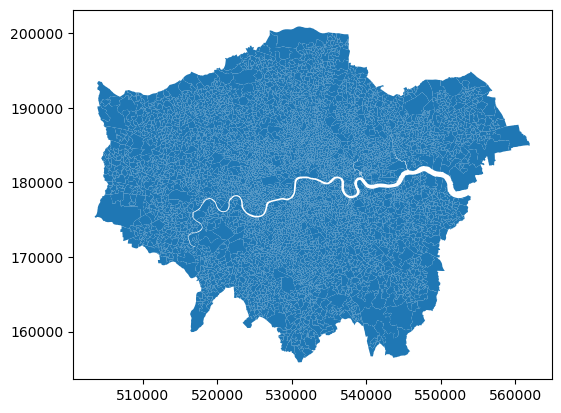

In [44]:
london.plot()